In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, time, timedelta
import warnings
import os
from tqdm import tqdm

warnings.filterwarnings('ignore')  # 过滤不必要的warnings
plt.rcParams["font.sans-serif"] = ['Hiragino Sans GB']  # set font
plt.rcParams["axes.unicode_minus"] = False  # solve "-"

In [4]:
''' 基本参数 '''
list_color = ['#044E7E', '#FF3333', '#367198', '#FF8080', '#81A6BE', '#FFB2B2', '#000000', '#999999','#666633','#996633']

begin_date = '2004-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')  

index_code = '000300.SH' # 沪深300代码

file_path = '/Users/tommylxt/Desktop/算法交易hw/基差因子'

In [5]:
df_bond_index = pd.read_excel(f'{file_path}/df_bond_index_pct.xlsx')
df_bond_index.rename(columns={'日期':'datetime'}, inplace=True)
df_bond_index['datetime'] = pd.to_datetime(df_bond_index['datetime'])

df_stock_index = pd.read_excel(f'{file_path}/df_{index_code}_data.xlsx')
df_stock_index.rename(columns={'日期':'datetime'}, inplace=True)
df_stock_index['datetime'] = pd.to_datetime(df_stock_index['datetime'])

df_diff = pd.read_csv('/Users/tommylxt/Desktop/算法交易hw/基差因子/汇总基差.csv')
df_diff.rename(columns={'Unnamed: 0':'datetime'}, inplace=True)
df_diff = df_diff[['datetime', '沪深300年化基差']]
df_diff['datetime'] = pd.to_datetime(df_diff['datetime'])

In [6]:
df_factor = df_stock_index.copy()

df_factor = pd.merge(df_factor, df_diff[['datetime', '沪深300年化基差']], on='datetime', how='left')

df_factor = pd.merge(df_factor, df_bond_index[['datetime', 'bond_index_pct']], on='datetime', how='left')
df_factor.set_index('datetime', inplace=True)

df_factor.head()

Unnamed: 0  index_close  沪深300年化基差  bond_index_pct
datetime                                                      
2019-12-23           0    3967.0962   0.032139        0.000988
2019-12-24           1    3992.9581   0.017420        0.000606
2019-12-25           2    3990.8671   0.009886        0.000444
2019-12-26           3    4025.9879   0.007364        0.000825
2019-12-27           4    4022.0278   0.028831        0.000104

In [7]:
''' 开仓信号 '''
def percentile_method_position(df, column, rolling_days, rolling_percentile):    
    # 计算滚动百分位
    df['rolling_percentile'] = df[column].rolling(window=rolling_days).apply(lambda x: x.rank(pct=True).iloc[-1], raw=False)
    
    # 初始化position列
    df['position'] = np.nan
    
    # 根据滚动百分位设置position的值
    df.loc[df['rolling_percentile'] >= rolling_percentile, 'position'] = 1
    df.loc[df['rolling_percentile'] <= rolling_percentile, 'position'] = -1
    df['position'].fillna(method='ffill', inplace=True)
    df['position'] = df['position'].shift(1)
    df.dropna(inplace=True)
    return df



''' 计算择时净值 '''
def calculate_nav(df):
    df['index_return'] = df['index_close'].pct_change()
    # position为1，持有标的；position为-1，持有十年期国债
    df['timing_return'] = df['index_return'] * (df['position'].replace(-1, 0)) \
                        - df['bond_index_pct'] * (df['position'].replace(1, 0))
    df['index_nav'] = (1 + df['index_return']).cumprod()  
    df['timing_nav'] = (1 + df['timing_return']).cumprod()  
    df.dropna(inplace=True)
    return df


''' 绘制信号图 '''
def plot_signal(df):
    fig, ax1 = plt.subplots(figsize=(10, 5), dpi=150)  # 创建图形大小和分辨率。

    # 为多信号绘制蓝色区域
    ax1.fill_between(df.index, 0, 1, where=(df['position'] > 0), color=list_color[2], alpha=0.6, label='做多信号')
    # 为空信号绘制绿色区域
    ax1.fill_between(df.index, 0, 1, where=(df['position'] < 0), color='white', label='做空信号')
    
    ax1.set_xlim(df.index.min(), df.index.max())  # 设置x轴为DataFrame索引的最小值到最大值
    ax1.set_ylim(0, 1)  # 设置y轴的范围以容纳-1到1的信号
    
    # 绘制收盘价曲线
    ax2 = ax1.twinx()  # 创建与ax1共享x轴的ax2
    ax2.plot(df['index_close'], color=list_color[1], label='标的收盘价(右轴)')
    ax2.set_ylim(df['index_close'].min(), df['index_close'].max())  # 设置ax2的y轴范围以显示收盘价数据

    # 设置图例位置
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()
    plt.close() 
    
    
    
def plot_nav_curve(df):
    # 绘制策略表现
    fig = plt.figure(figsize=(10, 5), dpi=150)
    ax1 = fig.add_subplot(111)
    df[['index_nav', 'timing_nav']].plot(ax=ax1, color=list_color, legend=False)
    xlim = ax1.set_xlim(df.index.min(), df.index.max())
    legend = ax1.legend(['标的净值', '策略净值'])
    grid = ax1.grid(True, which='both', linestyle='--', linewidth=0.25)
    plt.show()
    
    
''' 计算策略效果 '''
period = 252

def calculate_strategy_effect(df, period):
    ''' 计算年化收益 '''
    initial_nav = df['timing_nav'].iloc[0]
    final_nav = df['timing_nav'].iloc[-1]
    annual_return = (final_nav / initial_nav) ** (period / (len(df) - 1)) - 1 
    
    ''' 计算年化波动率 '''    
    annual_std = df['timing_return'].std() * np.sqrt(period)
    
    ''' 计算夏普 '''
    sharpe = annual_return / annual_std
    
    ''' 计算最大回撤 '''
    df['pre_peak'] = df['timing_nav'].cummax()
    df['maximum_drawdown'] = df['timing_nav'] / df['pre_peak'] - 1
    maximum_drawdown = df['maximum_drawdown'].min()
    return annual_return, annual_std, sharpe, maximum_drawdown

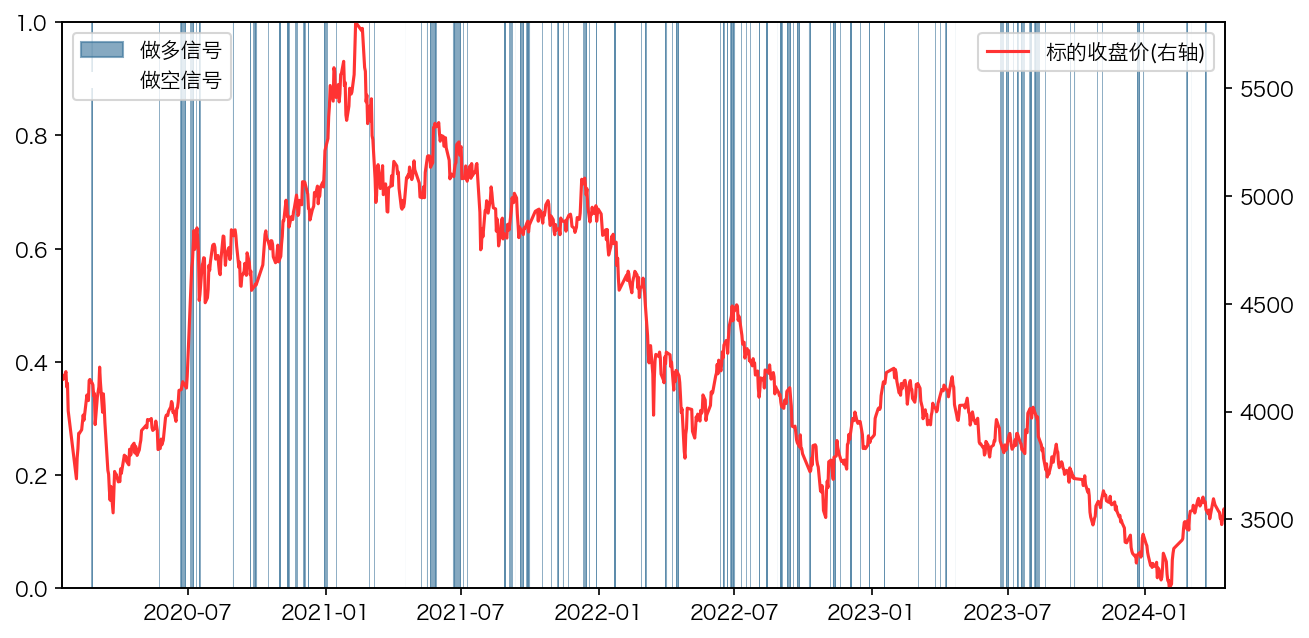

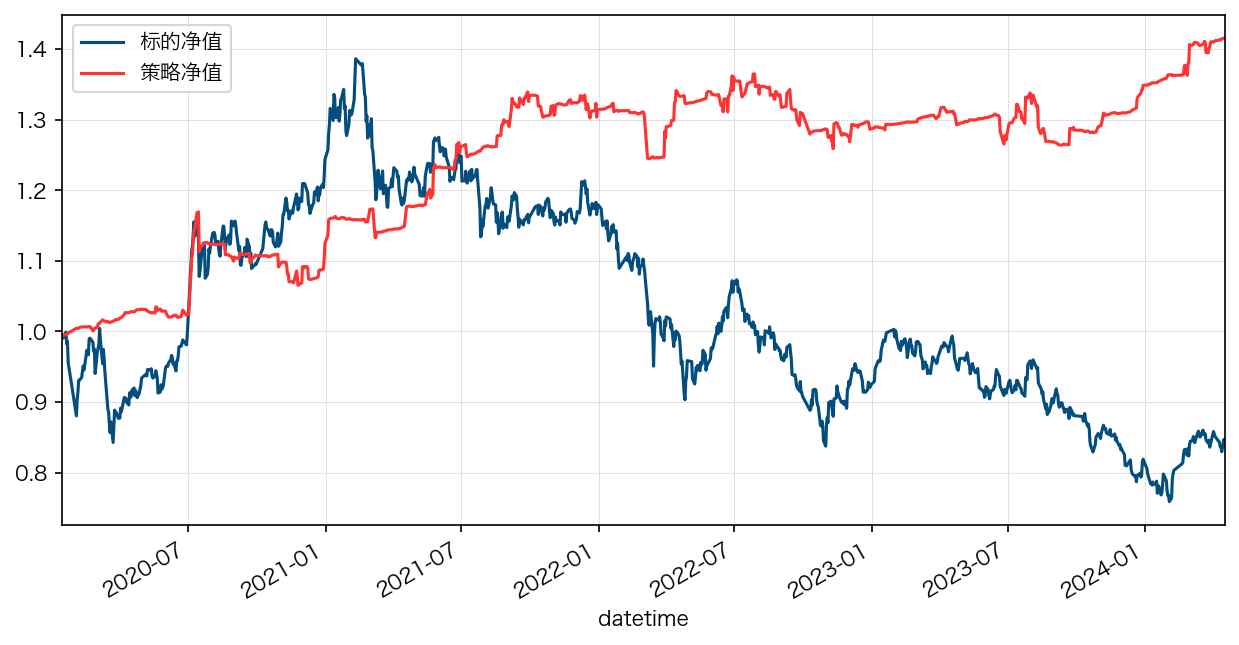


------------------- strategy effect ---------------------
annual return: 9.04%
annual std: 8.65%
sharpe ratio: 1.0451
maximum drawdown: -8.92%



In [8]:
rolling_days = 15
rolling_percentile = 0.8

df_position = percentile_method_position(df_factor, '沪深300年化基差', rolling_days, rolling_percentile)
calculate_nav(df_position)
plot_signal(df_position)
plot_nav_curve(df_position)

strategy_effect = calculate_strategy_effect(df_position, period)

annual_return = strategy_effect[0]
annual_std = strategy_effect[1]
sharpe = strategy_effect[2]
maximum_drawdown = strategy_effect[3]

print(f'\n------------------- strategy effect ---------------------\n'
      f'annual return: {annual_return * 100:.2f}%\n'
      f'annual std: {annual_std * 100:.2f}%\n'
      f'sharpe ratio: {sharpe:.4f}\n'
      f'maximum drawdown: {maximum_drawdown * 100:.2f}%\n'
      )

In [16]:
df_factor_basis = df_factor.copy()
df_factor_basis.reset_index(inplace=True)
df_factor_basis = df_factor_basis[['datetime','沪深300年化基差']]
df_factor_basis.to_excel('/Users/tommylxt/Desktop/算法交易hw/相关系数/df_factor_basis.xlsx')
print('ok')

ok
